# XCast - Deterministic Forecast 
#### By Kyle Hall & Nachiketa Acharya 
We will use XCast Methods to create lead-1 deterministic precipitation forecasts for August-September 2021 for the Asia Region. We will use CPC-CMAP-URD observation data as the predictand, and correspondingGCM data from COLA-RSMAS-CCSM4, CANSIPSv2, and NCEP-CFSv2 as predictors.  Since our CPC data only goes from 1982 - 2014, we will use that as the training period, and the remaining 7 years of predictors to make forecasts. 

In this section, import your modules (and xcast) and use them to load your data into Xarray DataSet/ DataArray objects.  You'll have three in the end- X_TRAIN, X_TEST, and Y_TRAIN. All of them must be 4-Dimensional, with latitude, longitude, samples, and features (in this case, samples are years , and features are models). X_TRAIN and Y_TRAIN must be the same length along the sample dimension, and Y_TRAIN must be only length 1 in the feature dimension. 

When you pass these objects to XCast, you'll need to specify the names of each of these dimensions, so it knows what to do with what. the defaults are x_sample_dim="T", x_feature_dim="M", x_lat_dim="Y", and x_lon_dim="X". Anything that differs from that needs to be specified. (For both dimensions on X and Y, in case there's a Y. those will be y_lat_dim, etc). 

In [1]:
import src as xc 
import xarray as xr 
import matplotlib.pyplot as plt 

obs = xr.open_dataset('test_data/cpc_jaso_asia_full.nc', decode_times=False)
cola = xr.open_dataset('test_data/cola_jaso_asia_full.nc', decode_times=False)
cansipsv2 = xr.open_dataset('test_data/cansipsv2_jaso_asia_full.nc', decode_times=False)
cfsv2 = xr.open_dataset('test_data/cfsv2_jaso_asia_full.nc', decode_times=False)

Y = obs.expand_dims({'M':[0]}) * 3
X = xr.concat([cola, cfsv2, cansipsv2], 'M').assign_coords({'M':[0,1,2]})
X_TRAIN = X.isel(S=slice(None, -7))
X_TEST = X.isel(S=slice(-7, None))

### 1. Ensemble Mean 
This method uses the mean of the member models as a deterministic forecast.

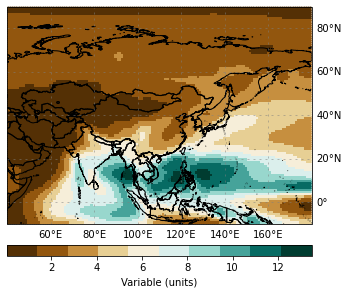

In [2]:
em = xc.EnsembleMean() 
em.fit(X_TRAIN.prec, Y.prate, x_sample_dim='S', verbose=True)
em_preds = em.predict(X_TEST.prec, x_sample_dim='S', verbose=True)
prob_map = xc.gaussian_smooth(em_preds, x_sample_dim='S')
xc.view_deterministic(prob_map, x_sample_dim='S', sample_ndx=-1)

### 2. Bias Corrected Ensemble Mean
This method averages independently standardized model data, then transforms it to the distribution of the observations data.  

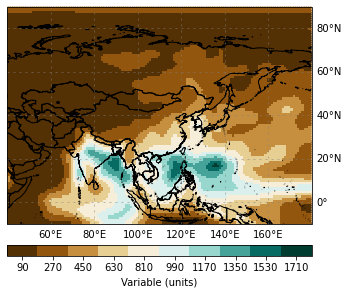

In [3]:
bcem = xc.BiasCorrectedEnsembleMean() 
bcem.fit(X_TRAIN.prec, Y.prate, x_sample_dim='S', verbose=True)
bcem_preds = bcem.predict(X_TEST.prec, x_sample_dim='S', verbose=True)
prob_map = xc.gaussian_smooth(bcem_preds, x_sample_dim='S')
xc.view_deterministic(prob_map, x_sample_dim='S', sample_ndx=-1, vmin=0, vmax=1800)

### 3. Multiple Linear Regression 

Fitting LinearRegression: 2021-08-06 19:52:59.552586 [*************************]
Predicting LinearRegression: 2021-08-06 19:53:03.659089 [*************************]


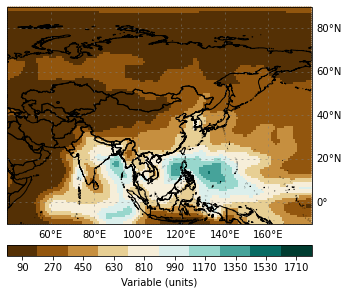

In [4]:
mlr = xc.MultipleLinearRegression() 
mlr.fit(X_TRAIN.prec, Y.prate, x_sample_dim='S', verbose=True)
mlr_preds = mlr.predict(X_TEST.prec, x_sample_dim='S', verbose=True)
prob_map = xc.gaussian_smooth(mlr_preds, x_sample_dim='S')
xc.view_deterministic(prob_map, x_sample_dim='S', sample_ndx=-1, vmin=0, vmax=1800)

### 4. Feature Principal Components Regression
This MME Applies PCA to the Feature dimension before regressing.

Fitting LinearRegression: 2021-08-06 19:53:20.176365 [*************************]
Predicting LinearRegression: 2021-08-06 19:53:25.554315 [*************************]


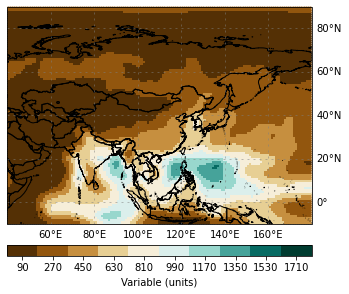

In [5]:
pcr = xc.PrincipalComponentsRegression() 
pcr.fit(X_TRAIN.prec, Y.prate, x_sample_dim='S', verbose=True)
pcr_preds = pcr.predict(X_TEST.prec, x_sample_dim='S', verbose=True)
prob_map = xc.gaussian_smooth(pcr_preds, x_sample_dim='S')
xc.view_deterministic(prob_map, x_sample_dim='S', sample_ndx=-1, vmin=0, vmax=1800)

### 5. Extreme Learning Machine (ELM)
This model implements ELM, which involves running the input data through randomly initialized perceptrons, then solving the output weights with the Moore-Penrose Generalized inverse.

Fitting ELM: 2021-08-06 19:53:35.138778 [*************************]
Predicting ELM: 2021-08-06 19:53:39.433088 [*************************]


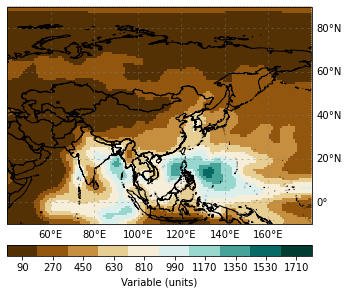

In [6]:
elm = xc.ExtremeLearningMachine(hidden_layer_size=50) 
elm.fit(X_TRAIN.prec, Y.prate, x_sample_dim='S', verbose=True)
elm_preds = elm.predict(X_TEST.prec, x_sample_dim='S', verbose=True)
prob_map = xc.gaussian_smooth(elm_preds, x_sample_dim='S')
xc.view_deterministic(prob_map, x_sample_dim='S', sample_ndx=-1, vmin=0, vmax=1800)

###  6. ELM with PCA (PCELM)
PCA is applied before fitting the ELM Model.

Fitting ELM: 2021-08-06 19:53:52.733529 [*************************]
Predicting ELM: 2021-08-06 19:53:57.464661 [*************************]


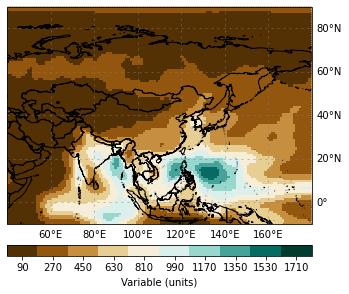

In [7]:
pcelm = xc.ExtremeLearningMachinePCA(hidden_layer_size=25) 
pcelm.fit(X_TRAIN.prec, Y.prate, x_sample_dim='S', verbose=True)
pcelm_preds = pcelm.predict(X_TEST.prec, x_sample_dim='S', verbose=True)
prob_map = xc.gaussian_smooth(pcelm_preds, x_sample_dim='S')
xc.view_deterministic(prob_map, x_sample_dim='S', sample_ndx=-1, vmin=0, vmax=1800)

### 7.  Ridge Regressor 

Fitting Ridge: 2021-08-06 19:54:12.702010 [*************************]
Predicting Ridge: 2021-08-06 19:54:17.113104 [*************************]


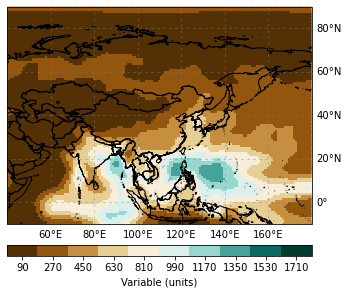

In [8]:
rid = xc.RidgeRegressor() 
rid.fit(X_TRAIN.prec, Y.prate, x_sample_dim='S', verbose=True)
rid_preds = rid.predict(X_TEST.prec, x_sample_dim='S', verbose=True)
prob_map = xc.gaussian_smooth(rid_preds, x_sample_dim='S')
xc.view_deterministic(prob_map, x_sample_dim='S', sample_ndx=-1, vmin=0, vmax=1800)

### 8. Poisson Regressor

Fitting PoissonRegressionOne: 2021-08-06 19:54:54.121097 [*************************]
Predicting PoissonRegressionOne: 2021-08-06 19:54:58.214862 [*************************]


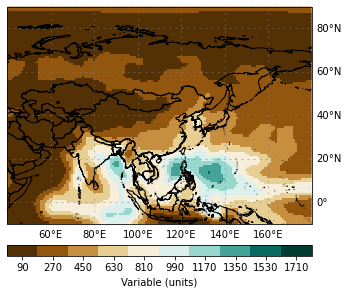

In [9]:
pr = xc.PoissonRegression() 
pr.fit(X_TRAIN.prec, Y.prate, x_sample_dim='S', verbose=True)
pr_preds = pr.predict(X_TEST.prec, x_sample_dim='S', verbose=True)
prob_map = xc.gaussian_smooth(pr_preds, x_sample_dim='S' )
xc.view_deterministic(prob_map, x_sample_dim='S', sample_ndx=-1, vmin=0, vmax=1800)

### 9. Gamma Regression

Fitting GammaRegressionOne: 2021-08-06 19:55:32.466376 [*************************]
Predicting GammaRegressionOne: 2021-08-06 19:55:36.655493 [*************************]


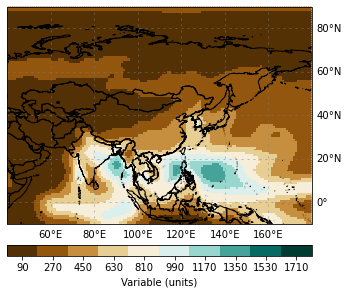

In [10]:
gam = xc.GammaRegression() 
gam.fit(X_TRAIN.prec, Y.prate, x_sample_dim='S', verbose=True)
gam_preds = gam.predict(X_TEST.prec, x_sample_dim='S', verbose=True)
prob_map = xc.gaussian_smooth(gam_preds, x_sample_dim='S' )
xc.view_deterministic(prob_map, x_sample_dim='S', sample_ndx=-1, vmin=0, vmax=1800)

### 10. Multi-Layer Perceptron  *** * Warning: Slow * ***

Fitting MLPRegressor: 2021-08-06 20:10:20.380865 [*************************]
Predicting MLPRegressor: 2021-08-06 20:10:24.351900 [*************************]


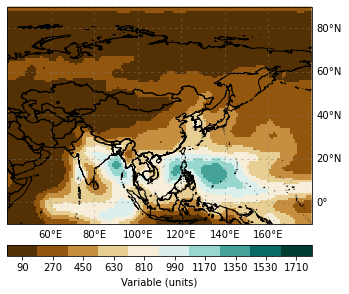

In [11]:
mlp = xc.MultiLayerPerceptron(hidden_layer_sizes=(5)) 
mlp.fit(X_TRAIN.prec, Y.prate, x_sample_dim='S', verbose=True)
mlp_preds = mlp.predict(X_TEST.prec, x_sample_dim='S', verbose=True)
prob_map = xc.gaussian_smooth(mlp_preds, x_sample_dim='S')
xc.view_deterministic(prob_map, x_sample_dim='S', sample_ndx=-1, vmin=0, vmax=1800)

### 11. Random Forest   *** * Warning: Slow * ***

Fitting RandomForestRegressor: 2021-08-06 20:33:31.091237 [*************************]
Predicting RandomForestRegressor: 2021-08-06 20:35:32.436458 [*************************]


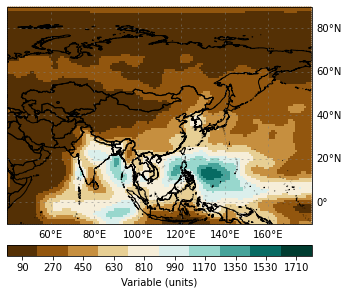

In [12]:
rf = xc.RandomForest() 
rf.fit(X_TRAIN.prec, Y.prate, x_sample_dim='S', verbose=True)
rf_preds = rf.predict(X_TEST.prec, x_sample_dim='S', verbose=True)
prob_map = xc.gaussian_smooth(rf_preds, x_sample_dim='S')
xc.view_deterministic(prob_map, x_sample_dim='S', sample_ndx=-1, vmin=0, vmax=1800)